In [ ]:
!pip install librosa numpy pandas scikit-learn tensorflow matplotlib

In [ ]:
pip list


In [1]:
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


In [2]:
import os

In [3]:
train_dir = './track-2-audio-identification-quest/training_split/training_split'
test_dir = './track-2-audio-identification-quest/testing_split/testing_split'

In [4]:
def get_list_of_files(dir_name):
    list_of_files = os.listdir(dir_name)
    all_files = []
    for entry in list_of_files:
        full_path = os.path.join(dir_name, entry)
        if os.path.isdir(full_path):
            all_files.extend(get_list_of_files(full_path))
        else:
            all_files.append(full_path)
    return all_files

In [5]:
# Get list of files
train_files = get_list_of_files(train_dir)
test_files = get_list_of_files(test_dir)

print(f"Number of training files: {len(train_files)}")
print(f"Number of testing files: {len(test_files)}")

Number of training files: 1453
Number of testing files: 637


In [6]:
# Load a sample audio file
sample_file = train_files[0]  # Just picking the first training file for now
audio, sr = librosa.load(sample_file, sr=None)  # sr=None to keep the original sample rate

print(f"Audio sample shape: {audio.shape}")
print(f"Sample rate: {sr}")

Audio sample shape: (441000,)
Sample rate: 44100


In [7]:
def extract_features(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    mel = librosa.feature.melspectrogram(y=audio, sr=sr)
    return np.concatenate([np.mean(mfccs, axis=1), np.mean(chroma, axis=1), np.mean(mel, axis=1)])


In [14]:
def extract_features_from_files(file_paths, feature_extractor):
    features = []
    for file_path in file_paths:
        feature = feature_extractor(file_path)
        features.append(feature)
    return np.array(features)

# Extract features for training and testing files
X_train = extract_features_from_files(train_files, extract_features)
X_test = extract_features_from_files(test_files, extract_features)

print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")


Training features shape: (1453, 153)
Testing features shape: (637, 153)


In [15]:
import re

def extract_labels_from_filename(filename):
    # Example filename: '132_70_female.wav'
    print(f"Processing filename:{filename}")
    match = re.search(r'(\d+)_([\d]+)_(male|female)_(\d+)\.wav', filename)
    if match:
        age = int(match.group(2))
        gender = match.group(3)
        
        # Determine age label
        if age <= 15:
            age_label = 0
        elif 16 <= age <= 40:
            age_label = 1
        else:
            age_label = 2
        
        # Determine gender label
        gender_label = 0 if gender == 'male' else 1
        
        return age_label, gender_label
    else:
        raise ValueError("Filename does not match expected format")


In [16]:
def extract_labels_from_files(file_paths):
    age_labels = []
    gender_labels = []
    for file_path in file_paths:
        try:
            age_label, gender_label = extract_labels_from_filename(os.path.basename(file_path))
            age_labels.append(age_label)
            gender_labels.append(gender_label)
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            
    return np.array(age_labels), np.array(gender_labels)


In [17]:
y_train_age, y_train_gender = extract_labels_from_files(train_files)

print(f"Training age labels shape: {y_train_age.shape}")
print(f"Training gender labels shape: {y_train_gender.shape}")

Processing filename:0_19_male_0.wav
Processing filename:0_19_male_1.wav
Processing filename:0_19_male_2.wav
Processing filename:0_19_male_3.wav
Processing filename:0_19_male_4.wav
Processing filename:0_19_male_5.wav
Processing filename:0_19_male_6.wav
Processing filename:0_19_male_7.wav
Processing filename:0_19_male_8.wav
Processing filename:100_30_female_0.wav
Processing filename:100_30_female_1.wav
Processing filename:100_30_female_2.wav
Processing filename:100_30_female_3.wav
Processing filename:100_30_female_4.wav
Processing filename:100_30_female_5.wav
Processing filename:100_30_female_6.wav
Processing filename:100_30_female_7.wav
Processing filename:100_30_female_8.wav
Processing filename:101_23_male_0.wav
Processing filename:101_23_male_1.wav
Processing filename:101_23_male_10.wav
Processing filename:101_23_male_11.wav
Processing filename:101_23_male_12.wav
Processing filename:101_23_male_13.wav
Processing filename:101_23_male_14.wav
Processing filename:101_23_male_15.wav
Proces

In [18]:
from sklearn.model_selection import train_test_split

# Split training data into training and validation sets
X_train, X_val, y_train_age, y_val_age, y_train_gender, y_val_gender = train_test_split(
    X_train, y_train_age, y_train_gender, test_size=0.2, random_state=42
)
#meaning age labels that i have made classified now
print(f"Validation features shape: {X_val.shape}")
print(f"Validation age labels shape: {y_val_age.shape}")
print(f"Validation gender labels shape: {y_val_gender.shape}")


Validation features shape: (291, 153)
Validation age labels shape: (291,)
Validation gender labels shape: (291,)


In [19]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and validation data
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Input
from tensorflow.keras.optimizers import Adam

# Define the model
input_layer = Input(shape=(X_train.shape[1], 1))
x = Conv1D(64, 3, activation='relu')(input_layer)
x = MaxPooling1D(2)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)

# Define two separate output layers
age_output = Dense(3, activation='softmax', name='age_output')(x)
gender_output = Dense(2, activation='softmax', name='gender_output')(x)

# Create the model
model = Model(inputs=input_layer, outputs=[age_output, gender_output])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={'age_output': 'sparse_categorical_crossentropy', 'gender_output': 'sparse_categorical_crossentropy'},
    metrics={'age_output': 'accuracy', 'gender_output': 'accuracy'}
)


In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 153, 1)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 151, 64)           │             256 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d (MaxPooling1D)  │ (None, 75, 64)            │               0 │ conv1d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 4800)              │               0 │ max_pooling1d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │         614,528 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ age_output (Dense)            │ (None, 3)                 │             387 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gender_output (Dense)         │ (None, 2)                 │             258 │ dense[0][0]                │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 615,429 (2.35 MB)

 Trainable params: 615,429 (2.35 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
#reshaping
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)  
print(X_val.shape)    



(1162, 153, 1)
(291, 153, 1)


In [19]:
history = model.fit(
    X_train, 
    {'age_output': y_train_age, 'gender_output': y_train_gender},
    epochs=200,  
    batch_size=32,  
    validation_data=(X_val, {'age_output': y_val_age, 'gender_output': y_val_gender}),
    verbose=1  # Set to 1 to see progress during training
)


Epoch 1/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - age_output_accuracy: 0.6533 - age_output_loss: 0.9631 - gender_output_accuracy: 0.6326 - gender_output_loss: 0.6473 - loss: 1.6106 - val_age_output_accuracy: 0.7526 - val_age_output_loss: 0.7220 - val_gender_output_accuracy: 0.7045 - val_gender_output_loss: 0.6084 - val_loss: 1.3120
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - age_output_accuracy: 0.7823 - age_output_loss: 0.6395 - gender_output_accuracy: 0.7105 - gender_output_loss: 0.5615 - loss: 1.2009 - val_age_output_accuracy: 0.7560 - val_age_output_loss: 0.6070 - val_gender_output_accuracy: 0.7045 - val_gender_output_loss: 0.5757 - val_loss: 1.1606
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - age_output_accuracy: 0.7735 - age_output_loss: 0.5317 - gender_output_accuracy: 0.7233 - gender_output_loss: 0.5297 - loss: 1.0616 - val_age_output_accuracy: 0.7801 - val_age_output_loss: 0.5460 - val_gender_output_accuracy: 0.7079 - val_gender_output_loss: 0.5434 - val_lo

In [24]:
# Extract features for test files
X_test = extract_features_from_files(test_files, extract_features)
X_test = scaler.transform(X_test)  # Apply the same scaling as training data
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))  # Reshape for the model


In [25]:
print(f"Number of test files: {len(test_files)}")
print(f"Shape of X_test: {X_test.shape}")

Number of test files: 637
Shape of X_test: (637, 153, 1)


In [26]:
print(f"Shape of X_test: {X_test.shape}")

Shape of X_test: (637, 153, 1)


In [27]:
predictions = model.predict(X_test, batch_size=32)   #637/32

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [34]:
# Define thresholds for fallback logic
lower_bound_threshold = 0.4 # Lower bound for confidence

# Extract probabilities for each sample
predicted_age_probs = predictions[0]  # Probabilities for age groups
predicted_gender_probs = predictions[1]
# Initialize an array for predicted labels
predicted_age_labels = np.argmax(predicted_age_probs, axis=1)
predicted_gender_labels = np.argmax(predicted_gender_probs, axis=1)

# Apply fallback mechanism so 0 can be included now,
for i, probs in enumerate(predicted_age_probs):
    if np.max(probs) < lower_bound_threshold:
        predicted_age_labels[i] = 0  # Assign to age group 0 if below threshold


# Print some predictions to check
print(predicted_age_labels[:10])  # Print first 10 predictions
print(predicted_gender_labels[:10])




[0 2 2 0 2 2 2 2 2 0]
[0 1 0 1 1 1 0 0 1 0]


In [35]:
import pandas as pd
import os

# Redefine the DataFrame with .wav extension removed
df = pd.DataFrame({
    'File_name': [os.path.splitext(os.path.basename(file))[0] for file in test_files],
    'Age_group': predicted_age_labels,
    'Gender': ['Male' if gender == 0 else 'Female' for gender in predicted_gender_labels]
})

print(f"Number of rows in DataFrame: {len(df)}")

# Print the first few rows to check the DataFrame
print(df.head())


Number of rows in DataFrame: 637
  File_name  Age_group  Gender
0         1          0    Male
1        10          2  Female
2      1000          2    Male
3       106          0  Female
4       107          2  Female


In [29]:
output_csv_path = 'sept,0.7.csv'
df.to_csv(output_csv_path, index=False)

#finished !!

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Age Confusion Matrix:
[[213   6]
 [ 17  55]]
Gender Confusion Matrix:
[[192  13]
 [  8  78]]


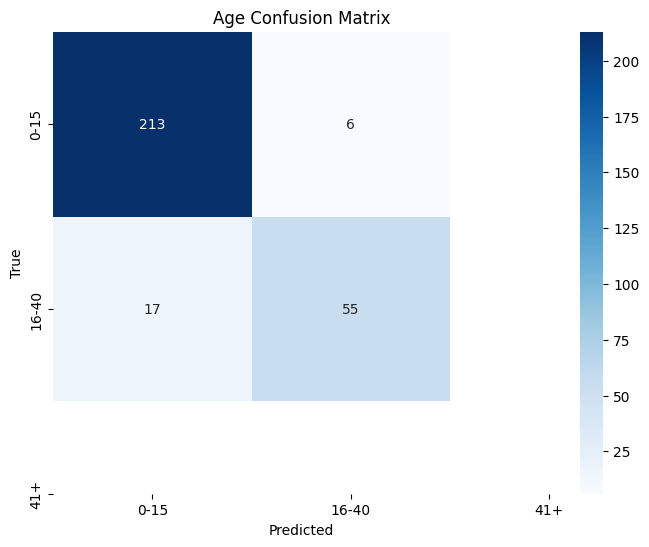

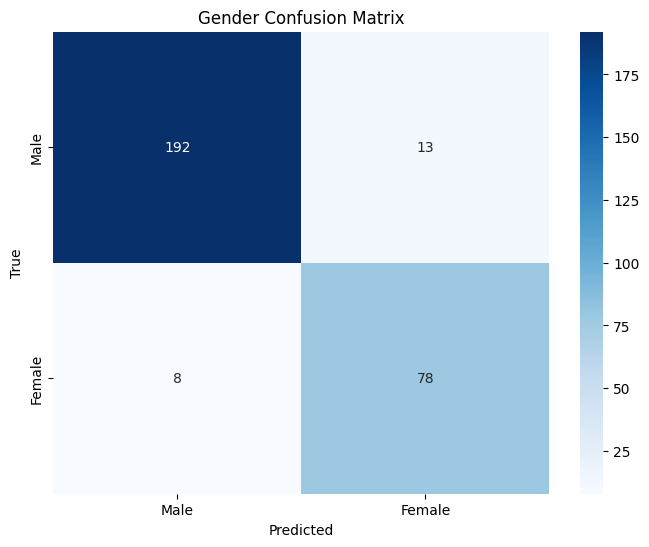

In [35]:
#not req really from now just for testing...
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# After training the model and making predictions
y_val_pred = model.predict(X_val)
y_val_age_pred = np.argmax(y_val_pred[0], axis=1)
y_val_gender_pred = np.argmax(y_val_pred[1], axis=1)

# Confusion matrix for age and gender
age_cm = confusion_matrix(y_val_age, y_val_age_pred)
gender_cm = confusion_matrix(y_val_gender, y_val_gender_pred)

# Print confusion matrices
print("Age Confusion Matrix:")
print(age_cm)
print("Gender Confusion Matrix:")
print(gender_cm)

# Visualize the confusion matrix for age
plt.figure(figsize=(8, 6))
sns.heatmap(age_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0-15', '16-40', '41+'], 
            yticklabels=['0-15', '16-40', '41+'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Age Confusion Matrix')
plt.show()

# Visualize the confusion matrix for gender
plt.figure(figsize=(8, 6))
sns.heatmap(gender_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Male', 'Female'], 
            yticklabels=['Male', 'Female'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Gender Confusion Matrix')
plt.show()


In [36]:
print(predicted_age_probs[:10])  # Print probabilities for the first 10 samples

[[5.1864925e-14 1.0000000e+00 5.3140820e-08]
 [1.3740738e-14 9.9999213e-01 7.8887060e-06]
 [9.7950625e-09 9.9409288e-01 5.9070806e-03]
 [2.1184845e-09 9.7879320e-01 2.1206850e-02]
 [6.2716412e-12 9.9999988e-01 1.7807086e-07]
 [2.9467185e-07 1.5143330e-01 8.4856635e-01]
 [7.5990436e-10 9.9904770e-01 9.5223205e-04]
 [3.3952901e-08 9.7609770e-01 2.3902280e-02]
 [4.6303175e-09 8.6973608e-01 1.3026388e-01]
 [1.8919879e-09 9.9983621e-01 1.6380861e-04]]


In [37]:
# Create a list of test file names
test_file_names = [os.path.basename(file) for file in test_files]

# Define the index you want to check
sample_index = 93# For example, if the index is 1

# Get the filename for that index
filename = test_file_names[sample_index]

# Print the filename
print(f"The filename for index {sample_index} is: {filename}")



The filename for index 93 is: 240.wav


In [38]:

specific_age_probs = predicted_age_probs[sample_index]
specific_gender_probs = predicted_gender_probs[sample_index]

print(f"Probabilities for age for sample {sample_index}: {specific_age_probs}")
print(f"Probabilities for gender for sample {sample_index}: {specific_gender_probs}")


Probabilities for age for sample 93: [1.0476315e-09 4.5138896e-01 5.4861104e-01]
Probabilities for gender for sample 93: [0.82280993 0.17719004]
